# Compare Designs by altering Spring K and Damping C

## Save Figures?

In [34]:
SAVE_FIG = True

## Imports

In [35]:
import csv
import re
import glob
import datetime
from pathlib import Path
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D     # 3D plotting functions
from scipy.interpolate import griddata      # interpolate package's griddate function is better
import numpy as np

from pogo_stick_jumping.jumping_ODE_Nonlinear import PogoODEnonlinear

## Set Up the Save Paths

In [36]:
current_path = Path.cwd()
compare_path = current_path / "compare_data" 
data_path = compare_path / "figures_data"
save_path = compare_path / "figures"
if not os.path.exists(data_path): 
    print(f"Made directory: {data_path}") 
    os.makedirs(data_path)
if not os.path.exists(save_path): 
    print(f"Made directory: {save_path}") 
    os.makedirs(save_path)


## Set up env parameters

In [37]:
m_act = 1.003               # mass of the pogo-stick rod (kg)
m_rod = 0.175               # mass of the pogo-stick rod (kg)

spring_k = 5760

zeta = 0.075

f = 11.13         # natural freq. (rad)
A_max = 63.2      # max acceleration of actuator (m/s^2)
V_max = 2.0       # max velocity of actuator (m/s)
Distance = 0.008  # Distance to move actuator in jump command (m)
Spring_Limit = -0.008
Spacing = 0.75 * (1 / f)  # Space commands by 0.5*period of oscillation

x_init = 0.0
x_dot_init = 0.0
x_act_init = 0.0
x_act_dot_init = 0.0

variance = 0.90
min_spring_k = np.round(spring_k - variance * spring_k, 4)
max_spring_k = np.round(spring_k + variance * spring_k, 4)
min_zeta = np.round(zeta - variance * zeta, 4)
max_zeta = np.round(zeta + variance * zeta, 4)

## Generate Plotting Data

In [38]:
# Set up the different combinations of springs and zetas to test
dim = 15
spring_k_line = np.linspace(min_spring_k, max_spring_k, dim, endpoint=True)
zeta_line = np.linspace(min_zeta, max_zeta, dim, endpoint=True)

k_grid, z_grid = np.meshgrid(spring_k_line, zeta_line)

x_grid = np.zeros((dim, dim))

for yy in range(dim):
    for xx in range(dim):

            k = k_grid[yy][xx]
            z = z_grid[yy][xx]

            pogo_stick = PogoODEnonlinear(m_act, m_rod, k, z, A_max, V_max, Distance, Spring_Limit, Spacing)
            x0 = [x_init, x_dot_init, x_act_init, x_act_dot_init]
            sim_time, timeseries = pogo_stick.run_simulation(x0, duration=1.0)
            height = np.max(timeseries[0])

            x_grid[yy][xx] = height

## Create a 3D plot of K vs. C. Vs Height

<ipython-input-39-04aecd6dd8ad>:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


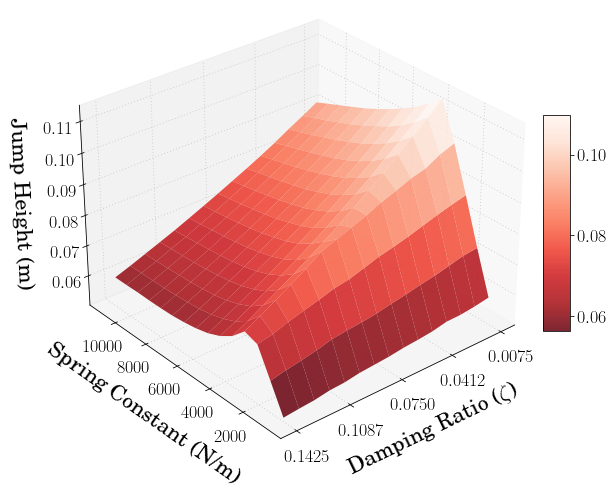

In [39]:
#-----  Copy from here down into your code, replacing items as needed ----------------
#   Many of these setting could also be made default by the .matplotlibrc file
fig = plt.figure(figsize=(9,6))
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
ax = Axes3D(fig)
ax.view_init(30,-130)
plt.setp(ax.get_ymajorticklabels(), fontsize=18)
plt.setp(ax.get_xmajorticklabels(), fontsize=18)
plt.setp(ax.get_zmajorticklabels(), fontsize=18)

padding = 12
yLabel = ax.set_xlabel(r'Damping Ratio ($\bf{\zeta}$)', fontsize=22, weight='bold', labelpad=padding)
xLabel = ax.set_ylabel(r'Spring Constant (N/m)', fontsize=22, weight='bold', labelpad=padding)
zLabel = ax.set_zlabel(r'Jump Height (m)', fontsize=22, weight='bold', labelpad=padding)
ax.invert_yaxis()

surf = ax.plot_surface(z_grid, k_grid, x_grid, linewidth=0, rstride=1, cstride=1, alpha=0.85, cmap=plt.cm.Reds_r, antialiased=True)
# cset = ax.contourf(k_grid, z_grid, x_grid, zdir='z', offset= -1, cmap=plt.cm.bwr)
# cset = ax.contour(k_grid, z_grid, x_grid, zdir='x', offset= np.max(k_grid), cmap=plt.cm.gray)
# cset = ax.contour(k_grid, z_grid, x_grid, zdir='y', offset=1.25*np.max(z_grid), cmap=plt.cm.gray)

# Adjust the limits as necessary
# ax.set_xlim3d(-1.25 * np.max(x), 1.25 * np.max(x))
# ax.set_ylim3d(0, 0.025)
# ax.set_zlim3d(0.01, 0.13)


# Adjust the axis ticks and their labels as necessary
# xticks([0,0.1,0.2,0.3,0.4,0.5])
yticks = np.linspace(zeta-zeta*0.9, zeta+zeta*0.9, 5)
ax.set_xticks(yticks)
# ax.set_xticklabels(['0.0175', '0.0125', '0.0075', '0.0025'])

# adjusts the padding around the 3D plot
ax.dist = 9

# Change the colorbar font
color_bar = plt.colorbar(surf,shrink=0.5,aspect=8)
cbytick_obj = plt.getp(color_bar.ax.axes, 'yticklabels')
plt.setp(cbytick_obj,  fontsize=18)

# Export to svg for final edits in iDraw/Graphic
name = save_path / 'Design_3D_Plot.pdf'
plt.savefig(name)
plt.show()

## Find the values related to spring and zeta and save them into separate data structures

In [40]:
m_rod = 0.175               # mass of the pogo-stick rod (kg)
m_act = 1.003               # mass of the pogo-stick rod (kg)
mass = m_rod + m_act        # total mass (kg)
f = 11.13                   # natural freq. (rad)
wn = f * (2 * np.pi)        # Robot frequency (rad/s)
zeta = 0.01                 # Robot damping ratio
c = 2 * zeta * wn * mass    # Calculate damping coeff
k = mass * wn**2            # Calulate spring constant
A_max = 63.2      # max acceleration of actuator (m/s^2)
V_max = 2.0       # max velocity of actuator (m/s)
Distance = 0.008  # Distance to move actuator in jump command (m)
Spring_Limit = -0.0075
Spacing = 0.75 * (1 / f)  # Space commands by 0.5*period of oscillation

x_init = 0.0
x_dot_init = 0.0
x_act_init = 0.0
x_act_dot_init = 0.0

spring_k = 3558
zeta = 0.00755
        
pogo_stick = PogoODEnonlinear(m_act, m_rod, spring_k, zeta, A_max, V_max, Distance, Spring_Limit, Spacing)

x0 = [x_init, x_dot_init, x_act_init, x_act_dot_init]
sim_time, timeseries = pogo_stick.run_simulation(x0, duration=1.0)

print("Max Height: ", np.max(timeseries[0]))


Max Height:  0.09751484997331751
